# 베드록 소개 - 베드록 임베딩으로 구축하기

> *오류가 발생하면 이 노트북에서 사용하는 베드록 모델에 대한 허용 목록에 추가해야 할 수 있습니다*

> *이 노트북은 SageMaker Studio의 **`Data Science 3.0`** 커널에서 잘 작동해야 합니다*


이 데모 노트북에서는 임베딩 생성을 위해 베드록 파이썬 SDK를 활용하는 방법을 보여드리겠습니다.

참고: 이 노트북은 Amazon SageMaker Studio의 Python 3 (Data Science 2.0) 커널에서 테스트되었습니다.

### 1. 설정

In [2]:
%pip install -U boto3 botocore --force-reinstall --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
apache-beam 2.50.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.0 which is incompatible.
awscli 1.29.57 requires botocore==1.31.57, but you have botocore 1.31.62 which is incompatible.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.
jupyterlab 3.4.4 requires jupyter-server~=1.16, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab-server 2.10.3 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
llama-index 0.8.37 requires urllib3<2, but you have urllib3 2.0.6 which is incompatible.
opensearch-py 2.3.1 requires urllib3<2,>=1.21.1, but you have urllib3 2.0.6 which is incompatible.

#### 이제 Boto3를 활용해 아마존 베드록 SDK에 대한 연결을 설정해 보겠습니다

In [3]:
#### Un comment the following lines to run from your local environment outside of the AWS account with Bedrock access

#import os
#os.environ['BEDROCK_ASSUME_ROLE'] = '<YOUR_VALUES>'
#os.environ['AWS_PROFILE'] = '<YOUR_VALUES>'

In [4]:
import boto3
import json 

bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

Create new client
  Using region: us-west-2
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)


### 2. 임베딩 생성

임베딩은 생성형 AI와 일반적인 머신러닝의 핵심 개념입니다. 임베딩은 단어, 이미지, 비디오 같은 객체를 벡터 공간에 표현한 것입니다. 일반적으로 의미상으로 유사한 객체는 벡터 공간에서 서로 더 가까운 임베딩을 갖게 됩니다. 이는 의미 검색, 추천, 분류와 같은 활용 사례에 매우 유용합니다.

In [5]:
# We will be using the Titan Embeddings Model to generate our Embeddings.

def get_embedding(body, modelId, accept, contentType):
    response = bedrock.invoke_model(
        body=body, 
        modelId=modelId, 
        accept=accept, 
        contentType=contentType
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

body = json.dumps({"inputText": "explain generative AI to 5th graders"})
modelId = 'amazon.titan-embed-text-v1'
accept = 'application/json'
contentType = 'application/json'

embedding = get_embedding(body, modelId, accept, contentType)
print(embedding[0:10])

[-0.4296875, -0.47070312, -0.375, 0.107421875, 0.38867188, -0.17382812, -0.42773438, -0.00051116943, 0.22949219, 0.25195312]


### 3. 시맨틱 유사성

문장 임베딩의 활용 사례 중 하나는 유사한 의미를 가진 문장을 함께 클러스터링하는 것입니다. 아래 예시에서는 애완동물, 미국 도시, 색상이라는 세 가지 범주의 문장에 대한 임베딩을 계산합니다. 같은 범주에서 비롯된 문장이 서로 다른 범주의 문장보다 훨씬 더 가까운 임베딩 벡터를 가지고 있음을 확인할 수 있습니다. 구체적으로, 코드는 다음과 같은 작업을 수행합니다.
1. 베드록 임베딩 API가 각 문장에 대한 임베딩 벡터를 출력합니다.
2. 두 문장 간의 거리는 해당 임베딩 벡터의 코사인 유사도로 계산됩니다.
3. 임베딩 공간에서 두 문장 간의 거리를 시각화하는 히트맵이 생성됩니다. 색상이 진할수록 코사인 유사도가 더 크다는 것(거리가 더 가깝다는 것)을 나타냅니다.

참고: 두 벡터의 코사인 유사도는 길이가 1로 정규화된 벡터의 내적입니다.

In [6]:
import sklearn
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="BuPu",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


phrases = [
    # Animals
    "Shelbee's dog, Molly, is so cute.",
    "Antje hates cats.",
    "Chris' first dog was very cute.",
    # U.S. Cities
    "Chicago is the place where I'm from.",
    "I work in San Francisco.",
    "Washington D.C. is a great place to visit.",
    # Color
    "What is your favorite color?",
    "Is Molly brown?",
    "Are your eyes blue?"
]

embeddings = []

for phrase in phrases:
    query_response = get_embedding(
      body=json.dumps({"inputText": phrase}),
      modelId='amazon.titan-embed-text-v1', 
      accept='application/json', 
      contentType='application/json')

    embeddings.append(query_response)
    
embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product

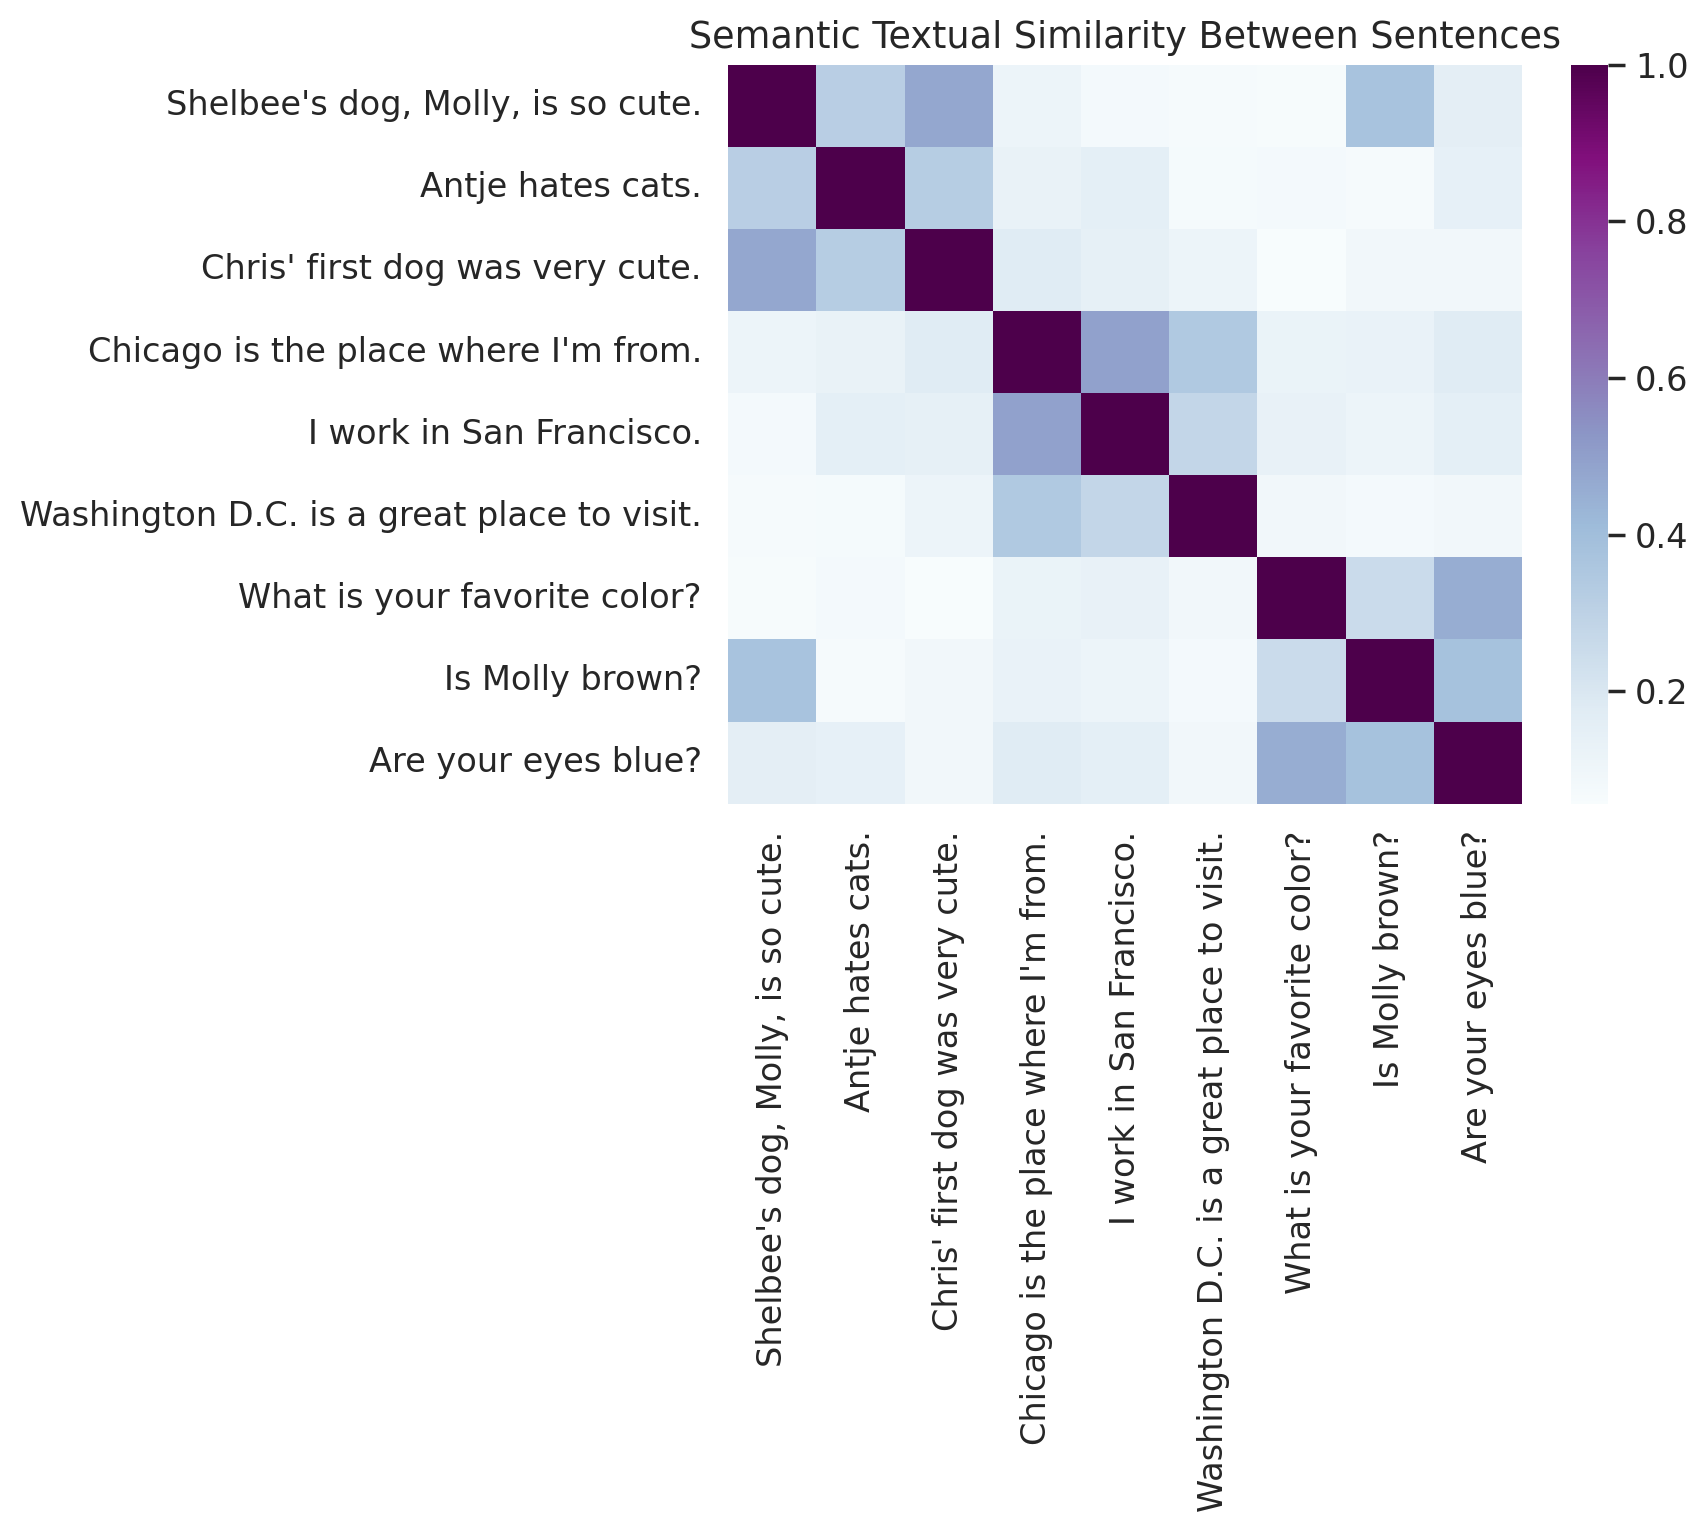

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plot_similarity_heatmap(phrases, embeddings, 90)